# Quantum Fisher Information Example

# Import Modules

In [21]:
import numpy as np
from qutip import *
from hyperopt import tpe, Trials, fmin, hp
import matplotlib.pyplot as plt

# Cavity QED Model - Functions

In [2]:
class model(object):
    """Quantum Rabi model with two-photon parametric driving."""

    def __init__(self, na: int, nc: int, wa: float, wc: float, g: float, use_rwa: bool) -> None:

        self.na = na                              # number qubits
        self.nc = nc                              # number cavity Fock states
        self.wa = wa                              # qubit frequency
        self.wc = wc                              # cavity mode frequency
        self.g = g                                # qubit-cavity interaction strength
        self.use_rwa = use_rwa                    # use rotating wave approximation

        self.si = qeye(2)                         # qubit identity operator
        self.ai = qeye(self.nc)                   # cavity mode identity operator

        self.op_list: list = []                   # operator list for constructing composite hamiltonian
        self.h: qutip.qobj.Qobj = 0               # composite hamiltonian
        self.a: qutip.qobj.Qobj = 0               # cavity, annihilation operator
        self.sms: list = []                       # qubits, lowering operators
        self.gen: qutip.qobj.Qobj = 0             # generator
        self.c_ops: list = []                     # collapse operators

    def qeye_op_list(self) -> None:
        """identity operator list of particles."""

        self.op_list = [self.si for _ in range(self.na)]
        self.op_list.extend([self.ai])

    def composite(self) -> None:
        """composite hamiltonian."""

        self.qeye_op_list()
        self.op_list[-1] = destroy(self.nc)
        self.a = tensor(self.op_list)
        self.h += self.wc * self.a.dag() * self.a

        for i in range(self.na):

            self.qeye_op_list()
            self.op_list[i] = destroy(2)
            sm = tensor(self.op_list)
            self.sms.append(sm)

            if self.use_rwa:
                self.h += self.wa * sm.dag() * sm + self.g * (self.a.dag() * sm + self.a * sm.dag())
            else:
                self.h += self.wa * sm.dag() * sm + self.g * (self.a.dag() + self.a) * (sm + sm.dag())
                
    def add_2photon_drive(self, r_max: float, tau: float) -> None:
        """add two-photon parametric drive.
        
        inputs
        r_max: max parametric gain
        tau: effective protocol speed"""
        
        lambda_ = '{0} * np.tanh( 2 * {1} * np.tanh( t / (2 * {2}) ) ) / 2'.format(self.wc, r_max, tau)
        self.h = [self.h, [-(self.a.dag() ** 2 + self.a ** 2), lambda_]] 

    def generator(self, bloch: np.ndarray) -> None:
        """generator for qfi.

        inputs
        bloch: qubit bloch vectors"""

        # reinitialize generator
        self.gen: qutip.qobj.Qobj = 0

        for i in range(self.na):
            self.qeye_op_list()
            self.op_list[i] = 0.5 * (bloch[i,0] * sigmax() + bloch[i,1] * sigmay() + bloch[i,2] * sigmaz())
            self.gen += tensor(self.op_list)

    def collapse_ops(self, qubit_diss: float, cavity_diss: float, n_cavity: float) -> None:
        """list of collpase operators.

        inputs
        qubit_diss: qubit dissipation rate
        cavity_diss: cavity relaxation rate
        n_cavity: average excitation thermal cavity"""

        # qubit dissipation
        rate = qubit_diss
        if rate > 0.0:
            for sm in self.sms:
                self.c_ops.append(np.sqrt(rate) * sm)

        # cavity relaxation
        rate = cavity_diss * (1 + n_cavity)
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a)

        # cavity excitation
        rate = cavity_diss * n_cavity
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a.dag())

In [3]:
def initiate_model(model_params: dict, drive_params: dict, collapse_params: dict) -> object:
    """initate model including 2 photon driving and collapse operators.
    
    model_params: model parameters
    drive_params: parametric driving parameters
    collapse params: collapse parameters"""
    
    model_ = model(**model_params)
    model_.composite()
    model_.add_2photon_drive(**drive_params)
    model_.collapse_ops(**collapse_params)
    
    return model_

# Quantum Fisher Information and Optimization - Functions

In [19]:
class qfi(object):
    """quantum fisher information."""

    def __init__(self, state: qutip.qobj.Qobj, gen: qutip.qobj.Qobj) -> None:

        self.state = state   # state
        self.gen = gen       # generator

    def pure(self) -> float:
        """qfi pure state.

        outputs
        4fq: qfi"""

        # compute qfi
        fq = variance(self.gen, self.state)

        return 4*np.real(fq)

    def mixed(self) -> float:
        """qfi mixed state.

        outputs
        4fq: qfi"""

        # eigenvalues, eigenstates of density matrix
        evals, evecs = self.state.eigenstates()

        # initialize qfi
        fq: float = 0

        # compute qfi
        for i in np.arange(evals.shape[0]):
            for j in np.arange(i):
                if evals[i] + evals[j] > 0:
                    fq += ((evals[i] - evals[j])**2/(evals[i] + evals[j]))*np.abs(self.gen.matrix_element(evecs[i], evecs[j]))**2

        return 4*np.real(fq)

In [4]:
class objectives(object):
    """objectives to be optimized."""

    def __init__(self, model: object, state: qutip.qobj.Qobj, state_type: str) -> None:

        self.model = model
        self.state = state
        self.state_type = state_type

    def optimize_qfi(self, params: dict) -> float:
        """optimize qfi over bloch vectors."""

        # reformat bloch vectors to cartesian
        bloch_xyz = dict_to_arrays_bloch(params)

        # update generator
        self.model.generator(bloch_xyz)

        # qfi
        qfi_ = qfi(self.state, self.model.gen)

        if self.state_type == 'pure':
            cost = (qfi_.pure() + 1e-10)**(-1)

        if self.state_type == 'mixed':
            cost = (qfi_.mixed() + 1e-10)**(-1)

        # cost
        return cost

In [5]:
def optimize(objective: callable, params: dict, max_evals: int) -> dict:
    """bayesian optimization.
    
    objective: objective function
    params: parameters to be optimized
    max_evals: max iterations"""

    # create algorithm
    tpe_algo = tpe.suggest

    # create trials object, tracks results
    tpe_trials = Trials()

    # run with tpe algorithm
    tpe_best = fmin(fn=objective, space=params,
                    algo=tpe_algo, trials=tpe_trials,
                    max_evals=max_evals)

    return tpe_best

In [6]:
def bloch_params(na: int) -> dict:
    """bloch vectors domain for optimization.

    inputs
    na: number of atoms

    outputs
    params: dict of bloch vectors domain"""

    # initialize parameters domain
    params = {}

    # build parameters domain
    for i in range(na):

        params['bloch theta {}'.format(i)] = hp.uniform('bloch theta {}'.format(i), 0, 2*np.pi)
        params['bloch phi {}'.format(i)] = hp.uniform('bloch phi {}'.format(i), 0, np.pi)

    return params

In [7]:
def dict_to_arrays_bloch(params: dict) -> tuple:
    """convert dict to arrays.

    inputs
    params: hyperopt parameters"""

    # make array
    bloch_sph = np.asarray([v for k, v in params.items()])

    # split by angles
    bloch_sph = np.split(bloch_sph, 2)

    # convert spherical to cartesian
    [bloch_xyz] = spherical_to_cartesian([np.asarray(bloch_sph).T])

    # molecule info in rows
    return np.asarray(bloch_xyz)

In [15]:
def spherical_to_cartesian(sphs: list) -> np.ndarray:
    """convert spherical to cartesian coordinates."""

    c_lists = []

    for x in sphs:

        c_list = [[np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)] for phi, theta in x]
        c_lists.append(c_list)

    return c_lists


# Example - Mixed State Evolution

In [50]:
# parameters
model_params = {'na': 2, 'nc': 10, 'wa': 2 * np.pi, 'wc': 2 * np.pi, 'g': 2, 'use_rwa': False}
collapse_params = {'qubit_diss': 0.005, 'cavity_diss': 0.05, 'n_cavity': 0}
dyn_params = {'t_final': 50, 'num': 10000}
psi0 = tensor(basis(2,1), basis(2,0), basis(model_params['nc'], 0)).unit()
params = bloch_params(model_params['na'])
max_evals = 1000
tlist = np.linspace(0, dyn_params['t_final'], dyn_params['num'])
num_dpts = 20
idx = np.linspace(0, tlist.shape[0] - 1, num_dpts, dtype='int')
qfi_opt = np.zeros(num_dpts)

In [51]:
# construct model, run dynamics
model_ = model(**model_params)
model_.composite()
model_.collapse_ops(**collapse_params)
outputs_states = mesolve(model_.h, psi0, tlist, model_.c_ops, [])
outputs_e_ops = mesolve(model_.h, psi0, tlist, model_.c_ops, [model_.sms[0].dag()*model_.sms[0], model_.sms[1].dag()*model_.sms[1], model_.a.dag()*model_.a])

100%|██████████| 1000/1000 [00:29<00:00, 29.29trial/s, best loss: 0.7023725632148846]


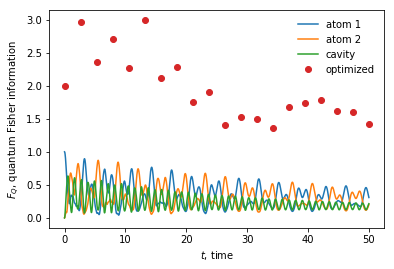

In [52]:
# compute Fisher information for select states
for i, state in enumerate([outputs_states.states[id_] for id_ in idx]):
    
    o_ = objectives(model_, state, 'mixed')
    tpe_best_ = optimize(o_.optimize_qfi, params, max_evals)
    qfi_opt[i] = o_.optimize_qfi(tpe_best_)**(-1)

plt.plot(tlist, outputs_e_ops.expect[0], label='atom 1')
plt.plot(tlist, outputs_e_ops.expect[1], label='atom 2')
plt.plot(tlist, outputs_e_ops.expect[2], label='cavity')
plt.plot(tlist[idx], qfi_opt, marker='o', lw=0, label='optimized')
plt.xlabel(r'$t$, time')
plt.ylabel(r'$F_{Q}$, quantum Fisher information')
plt.legend(frameon=False)